# Testing loss landscape for 2 layered system

In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product

    
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor, gen_loss_function
from Matrix_methods.AdamExtractor import LayeredExtractor

In [2]:
def compare_params(optim_params, material_params_exp):
    results = []

    for i, (opt, true) in enumerate(zip(optim_params, material_params_exp)):
        opt_nk, opt_d = opt
        true_nk, true_d = true

        # Extract n and k (remember: nk = n - i·k)
        n_opt = opt_nk.real
        k_opt = -opt_nk.imag

        n_true = true_nk.real
        k_true = -true_nk.imag

        # Residuals
        res_n = abs(n_opt - n_true)
        res_k = abs(k_opt - k_true)
        res_d = abs(opt_d - true_d)

        # Percentage errors
        perc_err_n = 100 * res_n / abs(n_true) if n_true != 0 else float('inf')
        perc_err_k = 100 * res_k / abs(k_true) if k_true != 0 else float('inf')
        perc_err_d = 100 * res_d / abs(true_d) if true_d != 0 else float('inf')

        results.append({
            'layer': i + 1,
            'n_opt': n_opt,
            'n_true': n_true,
            'res_n': res_n,
            'percent_error_n': perc_err_n,

            'k_opt': k_opt,
            'k_true': k_true,
            'res_k': res_k,
            'percent_error_k': perc_err_k,

            'd_opt': opt_d,
            'd_true': true_d,
            'res_d': res_d,
            'percent_error_d': perc_err_d,
        })

    return results

| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      3.300e-05 |
|            2.522 |        -0.003711 |      1.790e-04 |
(Negative absorption coeff means loss in the material.)

Total Thickness: 212.0 µm


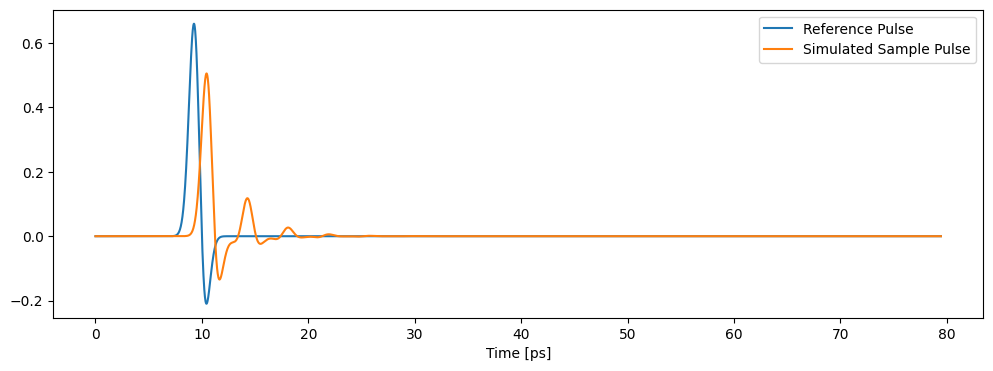

In [3]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n_values = [3.364, 2.522]
k_values = [-0.000356, -0.003711]
d_values = [3.3e-05, 0.000179]

# Experimental material parameters (ground truth)
material_params_exp = [[(n_values[i] + 1j * k_values[i]), d_values[i]] for i in range(len(n_values))]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print("| Refractive Index | Absorption Coeff | Thickness [µm] |")
print("|------------------|------------------|----------------|")

for item in material_params_exp:
    n_real = np.real(item[0])
    n_imag = np.imag(item[0])
    thickness = item[1]
    print(f"| {n_real:16.3f} | {n_imag:16.6f} | {thickness:14.3e} |")

print('(Negative absorption coeff means loss in the material.)')

print(f'\nTotal Thickness: {sum(d_values) * 1e6} µm')

plt.figure(figsize=(12,4))
#plt.title(f'Simulated Time Domain of THz Pulse Passing Through a {len(n_values)} Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
#plt.scatter(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), s=2, color= 'orange', label='Simulated Sample Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (2.914, 3.514)
Layer 1 - k ∈ (-0.001, 0.001)
Layer 2 - n ∈ (2.012, 2.6119999999999997)
Layer 2 - k ∈ (-0.001, 0.001)
[((3.3769133265286806+0.001j), 3.3e-05), ((2.517855655310769-0.001j), 0.000179)]


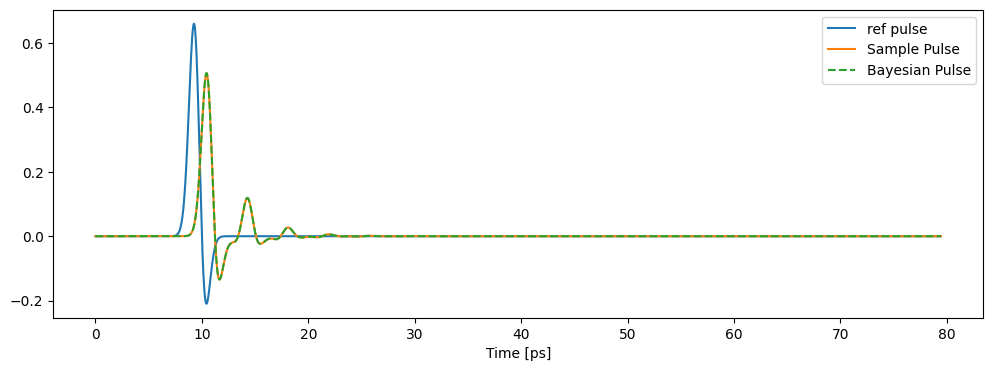

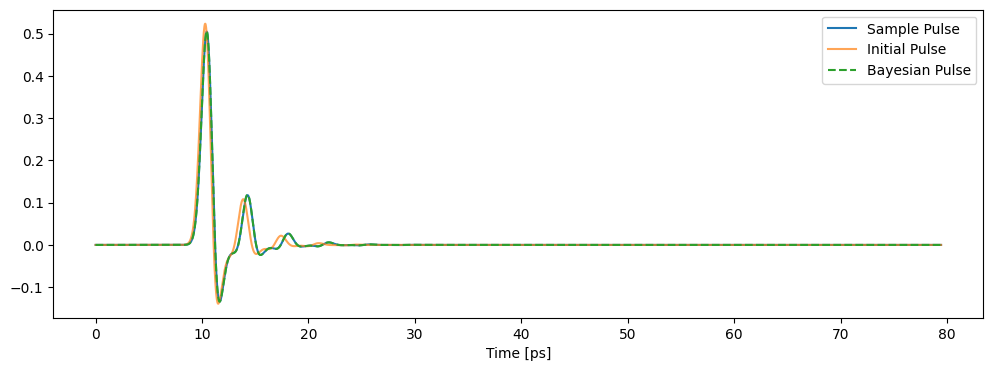

In [4]:

"""
Experimental params:
| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      3.300e-05 |
|            2.522 |        -0.003711 |      1.790e-04 |
"""

n_inits = [3.214, 2.312]
k_inits = [0, 0]
d_inits = [3.3e-05, 0.000179]


layers_init = [[(n_inits[i] + 1j * k_inits[i]), d_inits[i]] for i in range(len(n_inits))]

# Optimize with fixed thickness
optimization_mask = [
    (True, True, False),
    (True, True, False)
]

optimization_bounds = [0.3, 0.001, 0.15e-3]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimization_mask, optimization_bounds=optimization_bounds)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse')
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayesian Pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse')
plt.plot(t_axis*1e12, initial_pulse, label='Initial Pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayesian Pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Fine-tuning 4 parameters for 500 iterations.
Iteration 49, Loss: 6.724946e-05, Layer 0: n=3.3730, k=-0.00083, D=33.00 µm | Layer 1: n=2.5197, k=-0.00298, D=179.00 µm
Iteration 99, Loss: 2.711161e-05, Layer 0: n=3.3676, k=-0.00072, D=33.00 µm | Layer 1: n=2.5211, k=-0.00342, D=179.00 µm
Iteration 149, Loss: 2.249977e-06, Layer 0: n=3.3640, k=-0.00037, D=33.00 µm | Layer 1: n=2.5220, k=-0.00370, D=179.00 µm
Iteration 199, Loss: 1.928532e-06, Layer 0: n=3.3640, k=-0.00035, D=33.00 µm | Layer 1: n=2.5220, k=-0.00370, D=179.00 µm
Iteration 249, Loss: 1.478207e-06, Layer 0: n=3.3640, k=-0.00035, D=33.00 µm | Layer 1: n=2.5220, k=-0.00370, D=179.00 µm
Iteration 299, Loss: 7.088405e-07, Layer 0: n=3.3640, k=-0.00036, D=33.00 µm | Layer 1: n=2.5220, k=-0.00371, D=179.00 µm
Iteration 349, Loss: 6.140964e-07, Layer 0: n=3.3640, k=-0.00035, D=33.00 µm | Layer 1: n=2.5220, k=-0.00371, D=179.00 µm
Iteration 399, Loss: 5.931720e-07, Layer 0: n=3.3640, k=-0.00036, D=33.00 µm | Layer 1: n=2.5220, k=-0.

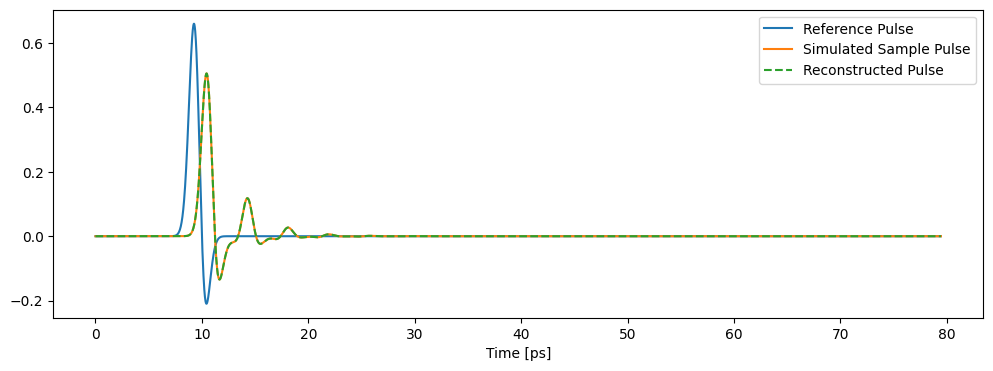

In [5]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.0001, optimize_mask=optimization_mask)
optim_params = LE.optimize(num_iterations=500, updates=50 , alpha=1)



_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='Reconstructed Pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

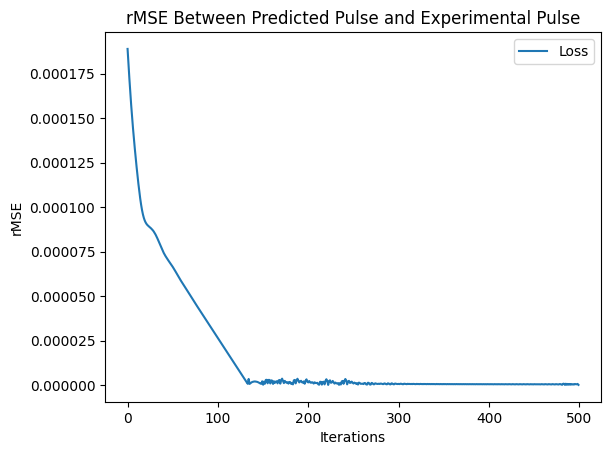

In [6]:
plt.plot(LE.loss_history, label='Loss')
plt.xlabel("Iterations")
plt.ylabel("rMSE")
plt.title("rMSE Between Predicted Pulse and Experimental Pulse")
plt.legend()
plt.show()

In [7]:
results = compare_params(optim_params, material_params_exp)

for r in results:
    print(f"Layer {r['layer']}:")
    print(f"  n: {r['n_opt']:.6f} (true: {r['n_true']:.6f}) | Residual: {r['res_n']:.2e} | % Error: {r['percent_error_n']:.2f}%")
    print(f"  k: {r['k_opt']:.6f} (true: {r['k_true']:.6f}) | Residual: {r['res_k']:.2e} | % Error: {r['percent_error_k']:.2f}%")
    print(f"  d: {r['d_opt']:.6e} (true: {r['d_true']:.6e}) | Residual: {r['res_d']:.2e} | % Error: {r['percent_error_d']:.2f}%\n")

Layer 1:
  n: 3.364012 (true: 3.364000) | Residual: 1.15e-05 | % Error: 0.00%
  k: 0.000330 (true: 0.000356) | Residual: 2.62e-05 | % Error: 7.35%
  d: 3.300000e-05 (true: 3.300000e-05) | Residual: 3.38e-12 | % Error: 0.00%

Layer 2:
  n: 2.522013 (true: 2.522000) | Residual: 1.32e-05 | % Error: 0.00%
  k: 0.003685 (true: 0.003711) | Residual: 2.59e-05 | % Error: 0.70%
  d: 1.789999e-04 (true: 1.790000e-04) | Residual: 7.76e-11 | % Error: 0.00%



## Explore loss by varying $n_i$ with $d_i$ & $k_i$ fixed at their correct values

In [8]:
# Define parameter limits and resolution
n_lims = [1.0, 5.0]
num_points = 200
n1_vals = np.linspace(*n_lims, num_points)
n2_vals = np.linspace(*n_lims, num_points)
n1_grid, n2_grid = np.meshgrid(n1_vals, n2_vals)

# Fixed parameters
k1, k2 = k_values # define these appropriately
d1, d2 = d_values
layer_d = [(None, d1), (None, d2)]  # we will fill in n + ik later

loss_fn = gen_loss_function

loss_grid = np.zeros_like(n1_grid)
log_loss_grid = np.zeros_like(n1_grid)

print('Exploring 2-layer parameter space:')
print(f'n1 range: {n1_vals[0]} to {n1_vals[-1]}')
print(f'n2 range: {n2_vals[0]} to {n2_vals[-1]}')

for idx, (i, j) in enumerate(tqdm(product(range(n1_grid.shape[0]), range(n1_grid.shape[1])), total=n1_grid.size, desc="Evaluating (n1, n2) grid")):
    n1 = n1_grid[i, j]
    n2 = n2_grid[i, j]

    # Create complex refractive indices for both layers
    layer = [(n1 + 1j * k1, d1), (n2 + 1j * k2, d2)]

    y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
    y_sim_tensor = y_sim.clone().detach()

    loss = loss_fn(y_sim_tensor, experimental_pulse).item()
    loss_grid[i, j] = loss
    log_loss_grid[i, j] = np.log(loss)

Exploring 2-layer parameter space:
n1 range: 1.0 to 5.0
n2 range: 1.0 to 5.0


Evaluating (n1, n2) grid: 100%|██████████| 40000/40000 [01:20<00:00, 499.17it/s]


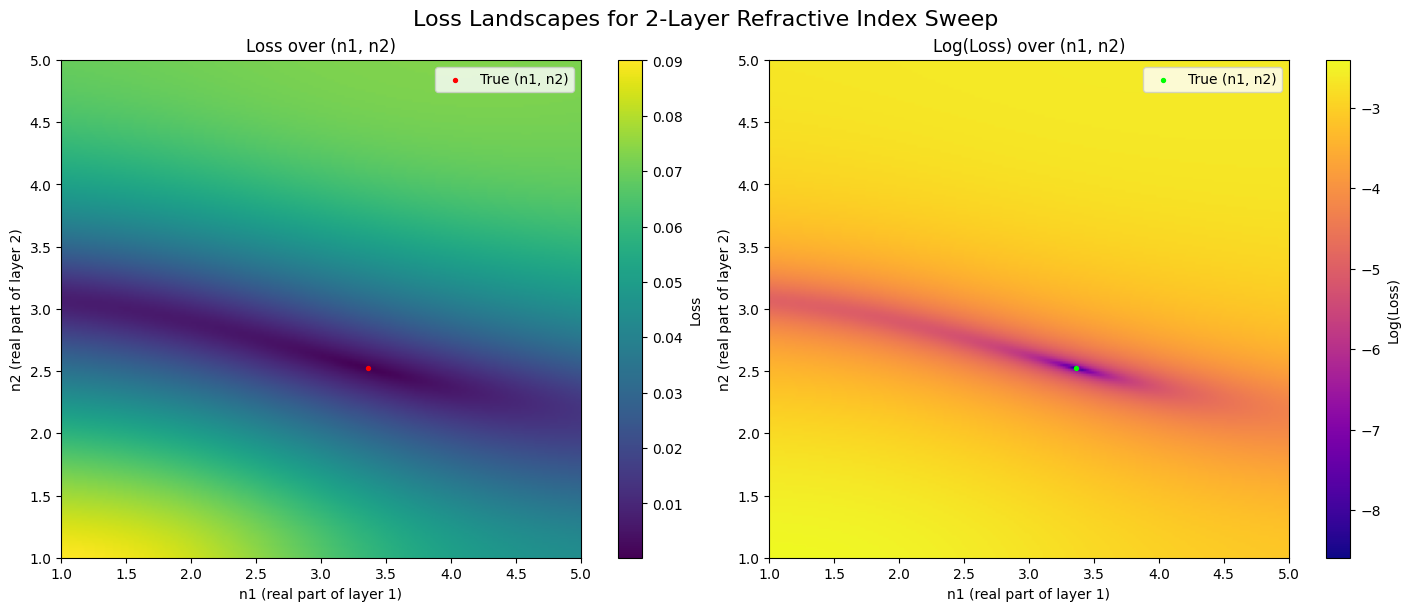

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot raw loss
im1 = axs[0].imshow(loss_grid, extent=[n1_vals[0], n1_vals[-1], n2_vals[0], n2_vals[-1]],
                    origin='lower', aspect='auto', cmap='viridis')
axs[0].scatter(n_values[0], n_values[1], color='red', label='True (n1, n2)', s=8)
axs[0].set_title("Loss over (n1, n2)")
axs[0].set_xlabel("n1 (real part of layer 1)")
axs[0].set_ylabel("n2 (real part of layer 2)")
fig.colorbar(im1, ax=axs[0], label='Loss')
axs[0].legend()

# Plot log-scaled loss
im2 = axs[1].imshow(log_loss_grid, extent=[n1_vals[0], n1_vals[-1], n2_vals[0], n2_vals[-1]],
                    origin='lower', aspect='auto', cmap='plasma')
axs[1].scatter(n_values[0], n_values[1], color='lime', label='True (n1, n2)', s=8)
axs[1].set_title("Log(Loss) over (n1, n2)")
axs[1].set_xlabel("n1 (real part of layer 1)")
axs[1].set_ylabel("n2 (real part of layer 2)")
axs[1].legend()
fig.colorbar(im2, ax=axs[1], label='Log(Loss)')

plt.suptitle("Loss Landscapes for 2-Layer Refractive Index Sweep", fontsize=16)

plt.show()

## Test how errors in n affect d and visa versa


In [10]:
def calc_n(t, d):
    c = 3e8
    return (t * c) / d

def calc_d(t, n):
    c = 3e8
    return (t * c) / n


t = 3*1e-12

print(calc_n(t, 100*1e-6))
print(calc_d(t, 9))

9.000000000000002
0.0001


In [11]:
from decimal import Decimal, getcontext

getcontext().prec = 25  # set high precision

def calc_n_decimal(t, d):
    c = Decimal("3e8")
    t = Decimal(str(t))
    d = Decimal(str(d))
    return (t * c) / d

print(calc_n_decimal(3e-12, 100e-6))  # outputs 9.0 exactly

9
